# Transposition of solar irradiance

In this tutorial you will learn how to calculate solar irradiance on a tilted surface using transposition models available in pvlib-python.

The first step is to import a few Python packages.

In [1]:
# Install pvlib on Google Colab as this is not a standard package.
!pip install pvlib

In [2]:
import pvlib  # library for PV and solar calculations
import pandas as pd  # library for data analysis
import matplotlib.pyplot as plt  # library for plotting
import numpy as np  # library for math and linear algebra

## Step 1: Retrieve example dataset
The next step is to load the example dataset, which contains hourly solar irradiance data for DTU.

The dataset is a typical meteorological year (TMY), meaning it consists of the most average month (irradiance wise) for a 10-year period. The data was retrieved from PVGIS, which we will investigate in the next lecture.

array([<Axes: xlabel='time(UTC)'>, <Axes: xlabel='time(UTC)'>,
       <Axes: xlabel='time(UTC)'>], dtype=object)

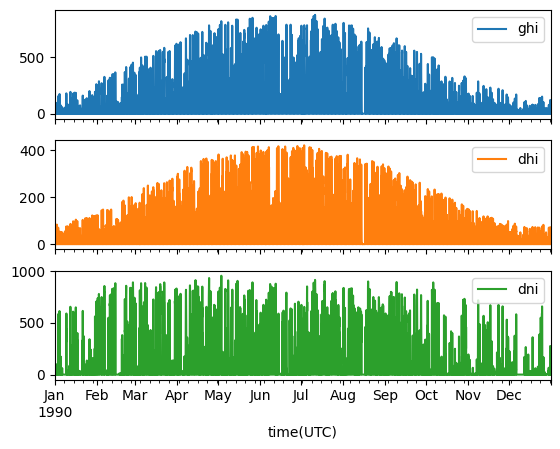

In [3]:
file_url = 'https://raw.githubusercontent.com/AdamRJensen/solar-resource-course/refs/heads/main/data/example_annual_dataset.csv'

data = pd.read_csv(file_url, index_col=[0], parse_dates=[0])

data.plot(subplots=True, sharex=True)

## Step 2: Calculate solar position

In [4]:
location = pvlib.location.Location(
    latitude=55.79,
    longitude=12.52,
)

solpos = location.get_solarposition(data.index)

## Step 3: Calculate extraterrestrial irradiance

In [5]:
data['dni_extra'] = pvlib.irradiance.get_extra_radiation(data.index)

## Step 4: Estimate in-plane irradiance

Estimate the in-plane irradiance of a tilted surface using the [Hay-Davies model](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.irradiance.haydavies.html). You may assume that the surface is tilted 30 degrees from horizontal and faces south.

For convenience, you may use the [pvlib.irradiance.get_total_irradiance](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.irradiance.get_total_irradiance.html) function.

<Axes: xlabel='time(UTC)'>

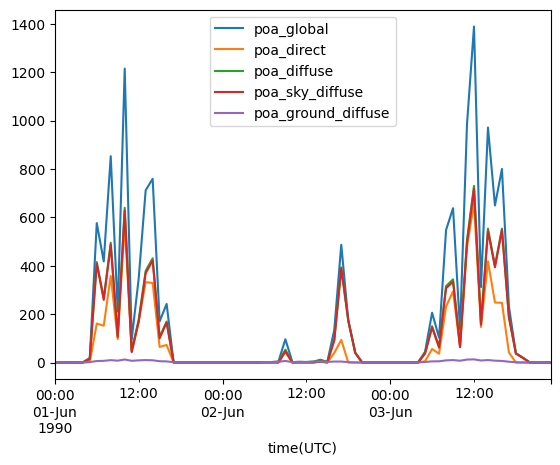

In [6]:
# Write your code here


#### SOLUTION ####
transposed_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=30,
    surface_azimuth=180,
    solar_zenith=solpos['apparent_zenith'],
    solar_azimuth=solpos['azimuth'],
    dni=data['dni'],
    ghi=data['ghi'],
    dhi=data['dni'],
    dni_extra=data['dni_extra'],
    albedo=0.25,
    model='haydavies',
)

# plot the transposed components for three days
transposed_irradiance['1990-06-01': '1990-06-03'].plot()

## Step 5: Determine which orientation has the highest annual solar irradiance

Determine which orientation has the highest incident annual solar irradiance. You can either do this by manually trying different combinations, or you can write a for loop that calculates the in-plane irradiance for all combinations of tilt and azimuth (e.g., in 1-degree increments).

*If you are feeling Python savvy, you can also use an optimization search algorithm to avoid having to search the entire design space.*


In [7]:
# write your code here

#### SOLUTION ####
annual_irradiance = pd.DataFrame(index=np.arange(0, 90, 1), columns=np.arange(90, 270, 2), dtype=float)
annual_irradiance.index.name = 'surface_tilts'
annual_irradiance.columns.name = 'surface_azimuths'

for surface_azimuth in annual_irradiance.columns:
    for surface_tilt in annual_irradiance.index:
        annual_transposed_irradiance = pvlib.irradiance.get_total_irradiance(
            surface_tilt=surface_tilt,
            surface_azimuth=surface_azimuth,
            solar_zenith=solpos['apparent_zenith'],
            solar_azimuth=solpos['azimuth'],
            dni=data['dni'],
            ghi=data['ghi'],
            dhi=data['dni'],
            dni_extra=data['dni_extra'],
            albedo=0.25,
            model='haydavies',
        )['poa_global'].sum()


        annual_irradiance.loc[surface_tilt, surface_azimuth] = annual_transposed_irradiance

In [8]:
optimum_surface_azimuth = annual_irradiance.max(axis=0).idxmax()
optimum_surface_tilt = annual_irradiance.max(axis=1).idxmax()
print(f"Optimum orientation\nSurface tilt: {optimum_surface_tilt}\nSurface_azimuth: {optimum_surface_azimuth}")

Optimum orientation
Surface tilt: 43
Surface_azimuth: 172


### Advanced solution: Plot the optimum

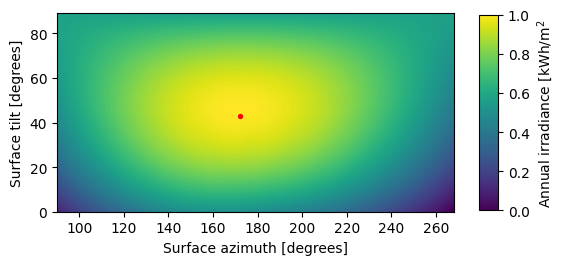

In [11]:
extent=[annual_irradiance.columns.min(), annual_irradiance.columns.max(), annual_irradiance.index.min(), annual_irradiance.index.max()] # left, right, bottom, top

plt.imshow(annual_irradiance.divide(1000), extent=extent)

plt.scatter(optimum_surface_azimuth, optimum_surface_tilt, c='r', s=8)

plt.colorbar(label="Annual irradiance [kWh/m$^2$", shrink=0.53, aspect=10)
plt.xlabel("Surface azimuth [degrees]")
plt.ylabel("Surface tilt [degrees]")
plt.show()